In [164]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [165]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [166]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [167]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [168]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables
Base.prepare(autoload_with=engine)

In [169]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [170]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [171]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [172]:
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
columns2 = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [173]:
for c in columns2:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [174]:
# Find the most recent date in the data set.

recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
recent_date

('2017-08-23',)

In [175]:
[session.query(measurement.date, measurement.prcp)]

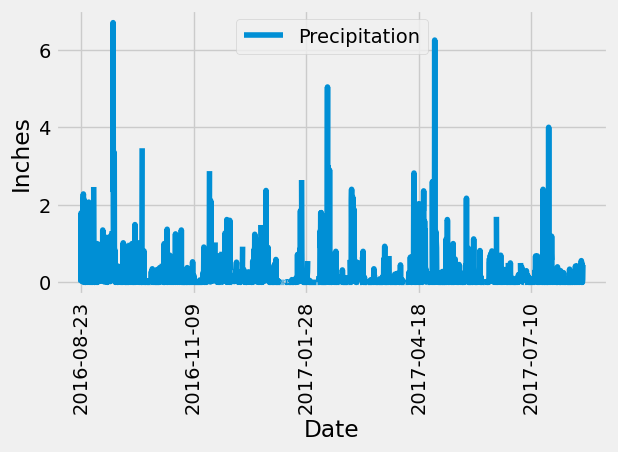

In [176]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
date_prc = session.query(measurement.date, measurement.prcp)
date_prc = date_prc.filter(measurement.date >= one_year).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
date_prc_updated = pd.DataFrame(date_prc, columns = ["Date", "Precipitation"])

# Sort the dataframe by date
date_prc_updated = date_prc_updated.sort_values("Date", ascending=False)

# Use Pandas Plotting with Matplotlib to plot the data
date_prc_updated.set_index("Date", inplace=True)
date_prc_updated = date_prc_updated.sort_index()
date_prc_updated.plot(rot=90, ylabel= "Inches")
plt.tight_layout()
plt.show()

In [177]:
# Use Pandas to calculate the summary statistics for the precipitation data
date_prc_updated.describe()


,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [178]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(station.station)).all()

[(9,)]

In [179]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_station = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()
most_active = active_station[0][0]
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [180]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [ 
       func.min(measurement.tobs), 
       func.max(measurement.tobs), 
       func.avg(measurement.tobs)]
most_functions = session.query(*sel).\
    filter(measurement.station == most_active).\
    order_by(measurement.station).all()
most_functions

[(54.0, 85.0, 71.66378066378067)]

In [182]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs

,tobs
0,81.0
1,79.0
2,80.0
3,79.0
4,77.0
...,...
1045,77.0
1046,77.0
1047,76.0
1048,76.0


<Axes: ylabel='Frequency'>

<Figure size 640x480 with 0 Axes>

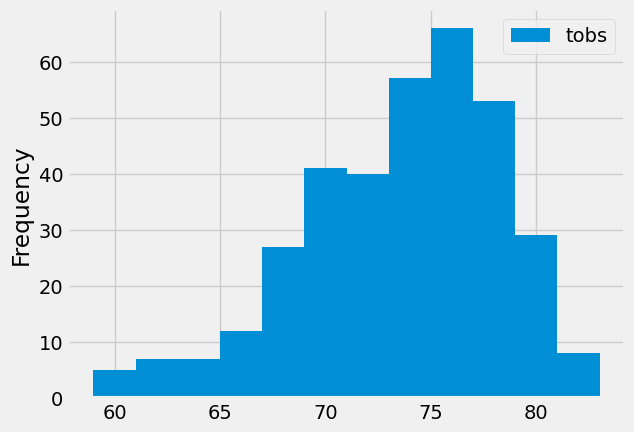

In [183]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs = session.query(measurement.tobs).\
    filter((measurement.date >= one_year) & (measurement.station == most_active)).all()
temp_obs = pd.DataFrame(temp_obs)
plt.tight_layout()
temp_obs.plot(kind = "hist", bins = 12)

# Close Session

In [163]:
# Close Session
session.close()